In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

# misc commands for plot style
n = 16
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, n))
plt.show()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])
plt.rcParams['font.size'] = 16


# Mass Function
To make predicitions for the halo mass function $dn / dM$, you need to provide three things:

1. A dictionary containing your cosmology with entries
- `10^9 As`: $10^9As $
- `ns`: Spectral index
- `H0`: Hubble parameter in `[km/s/Mpc]`
- `w0`: Dark Energy Equation fo State
- `ombh2`: $Ω_b h^2$
- `omch2`: $Ω_m h^2$
- `nu_mass_ev`: Neutrino mass sum in `[eV]`
2. A vector or scalar of halo mass(es) in units of `[Msol/h]`
3. The scale factor you wish to evaluate the massfunction at

In [3]:
from aemulusnu_hmf.emulator import dn_dM

In [4]:
Ms = np.logspace(12, 16, 100) #in units of Msol / h
a_s = np.linspace(0.5, 1, n) #scale factor
cosmology = {'ns': 0.97,
 'H0': 67.0,
 'w0': -1.0,
 'ombh2': 0.0223,
 'omch2': 0.12,
 'nu_mass_ev': 0.07,
 '10^9 As': 2.1}

A note about how the emulator works: when you pass `dn_dM` a new cosmology for the first time, it will first use `classy` to precompute a lot of quantities needed to compute the halo mass function. This will only happen the first time you pass this cosmology. 

In [5]:
%%timeit -n 1 -r 1
#the first time you call dn_dM with a new cosmology, 
#it will take some time to precompute some quantites
dn_dM(cosmology, 1e14, 1.0)

initializing cosmology. this will only happen once per cosmology
14.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
%%timeit
#now that all the cosmology quantities are computed, this will be much faster
dn_dM(cosmology, 1e14, 1.0)

52.7 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With all this we can now start making predicitions

[]

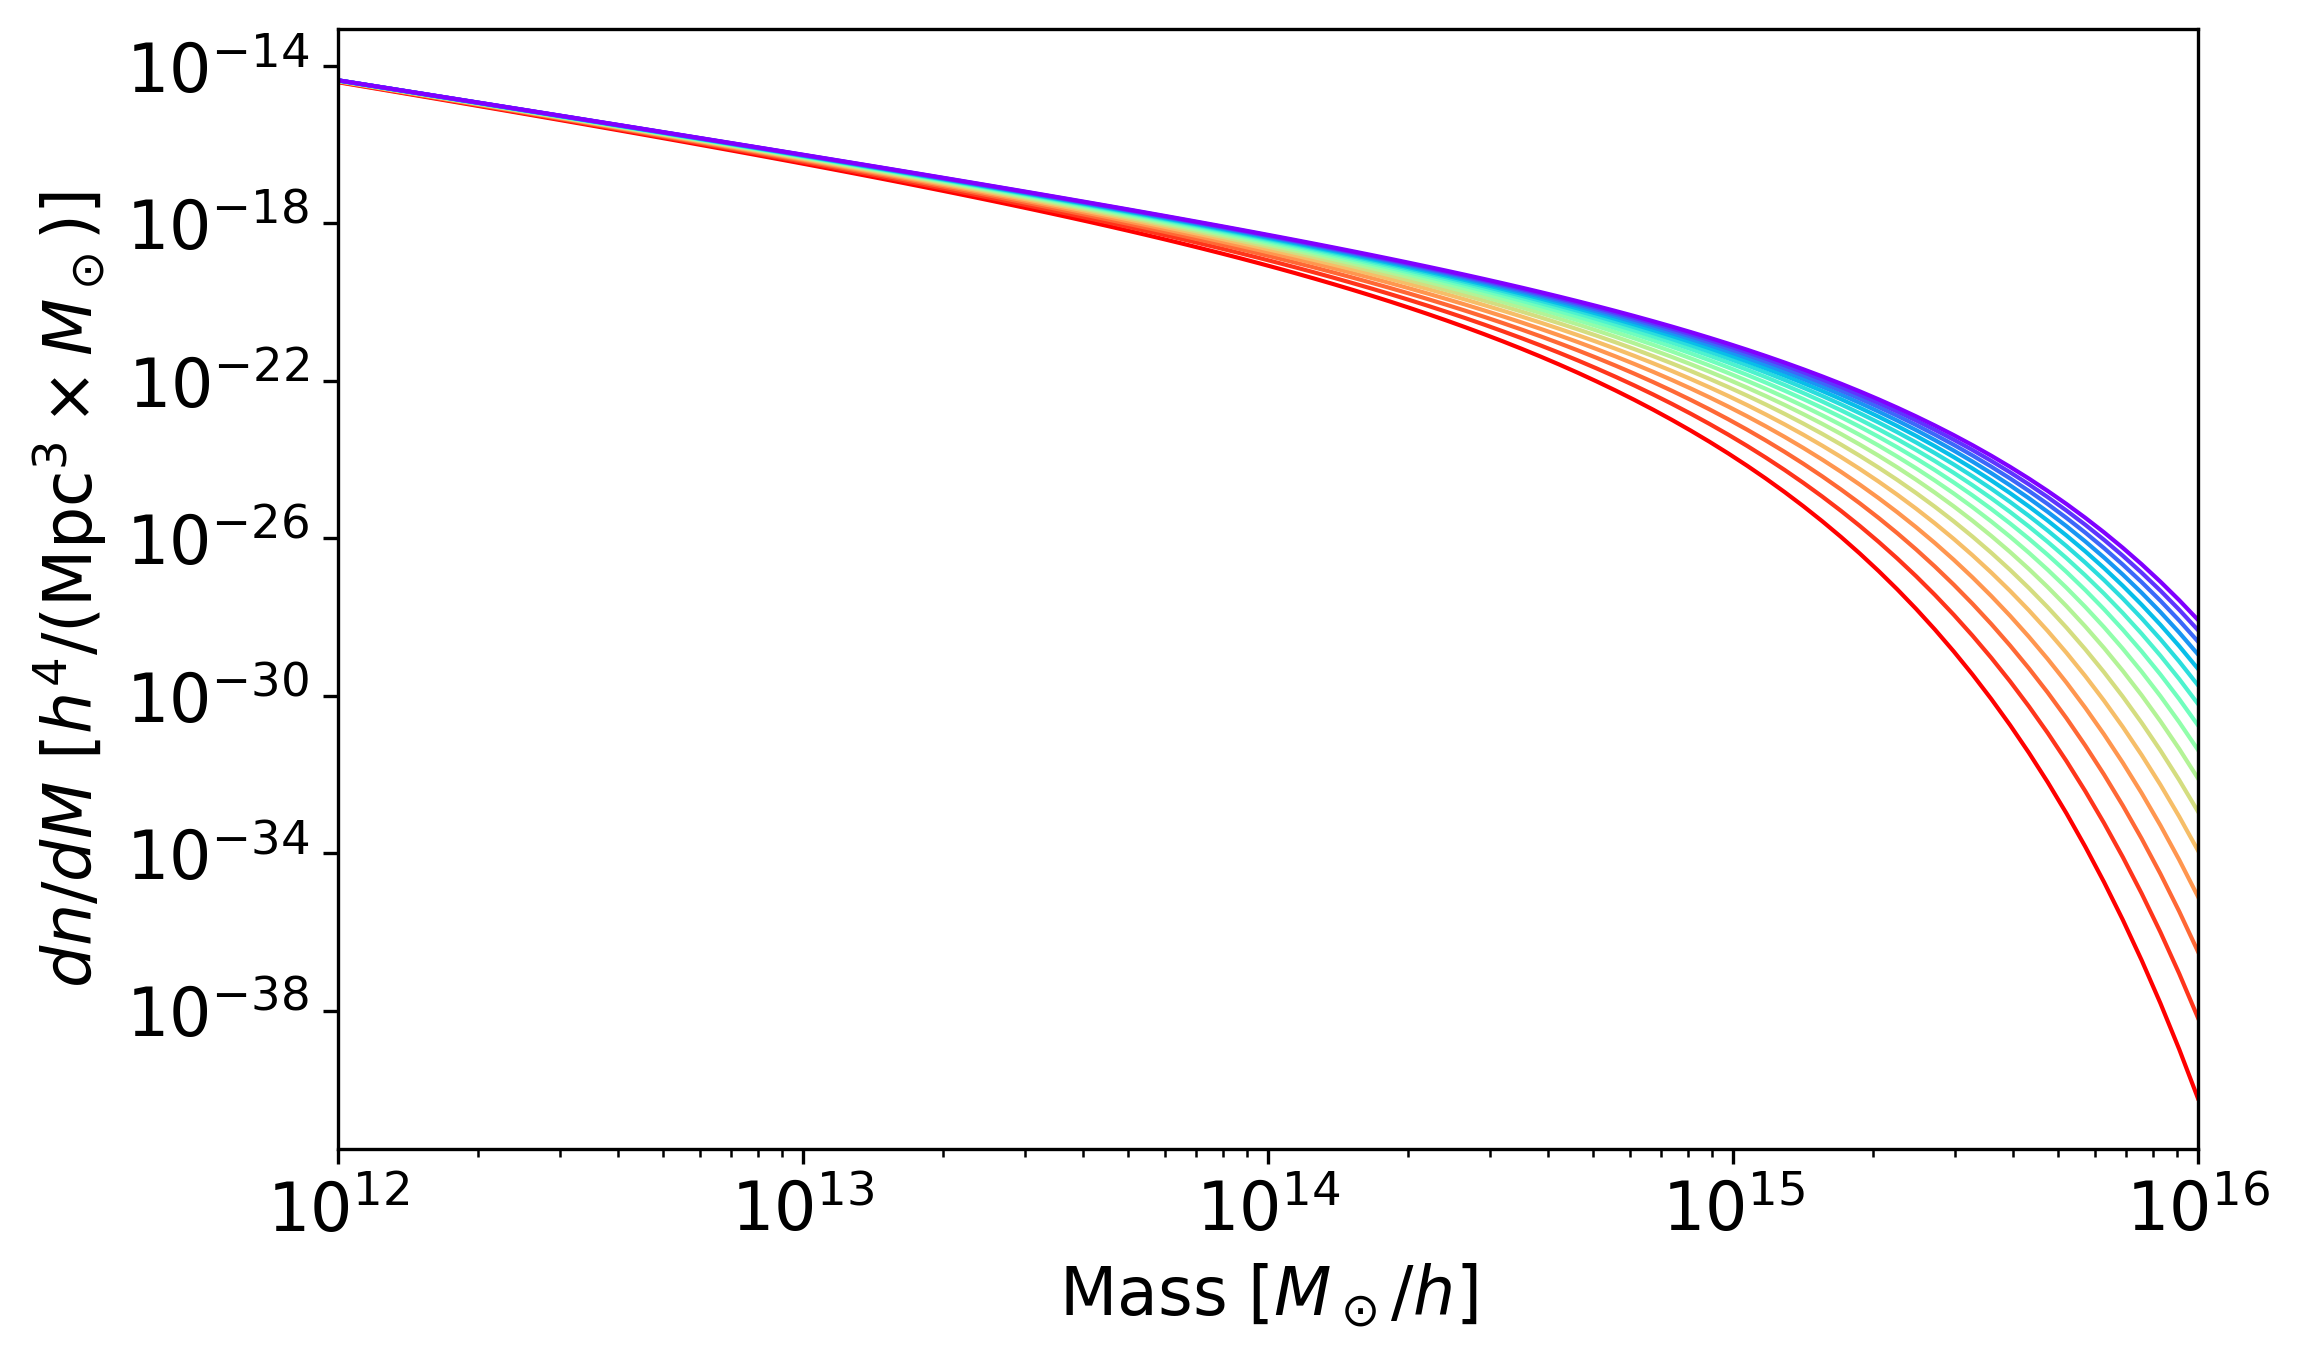

In [7]:
plt.figure(dpi=300, figsize = (8,8/1.618))
for a in a_s:
    plt.plot(Ms, dn_dM(cosmology, Ms, a), 
             lw = 1)
    
plt.xlim(1e12, 1e16)
plt.xlabel(r'Mass [$M_\odot / h$]')
plt.ylabel(r'$dn/dM\ [h^4 / ({\rm Mpc}^3  \times M_\odot)]$')

plt.loglog()

## Faster Evaluation of the Mass Function
We saw above that initializing a new cosmology took ~10 seconds. The main `classy` setting that causes this large time cost is the accuracy setting `ncdm_quadrature_strategy`. We can relax the accuracy setting by passing `fast = True` to `dn_dM`

In [8]:
%%timeit -n 1 -r 1
dn_dM(cosmology, 1e14, 1.0, fast = True)

initializing cosmology. this will only happen once per cosmology
1.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


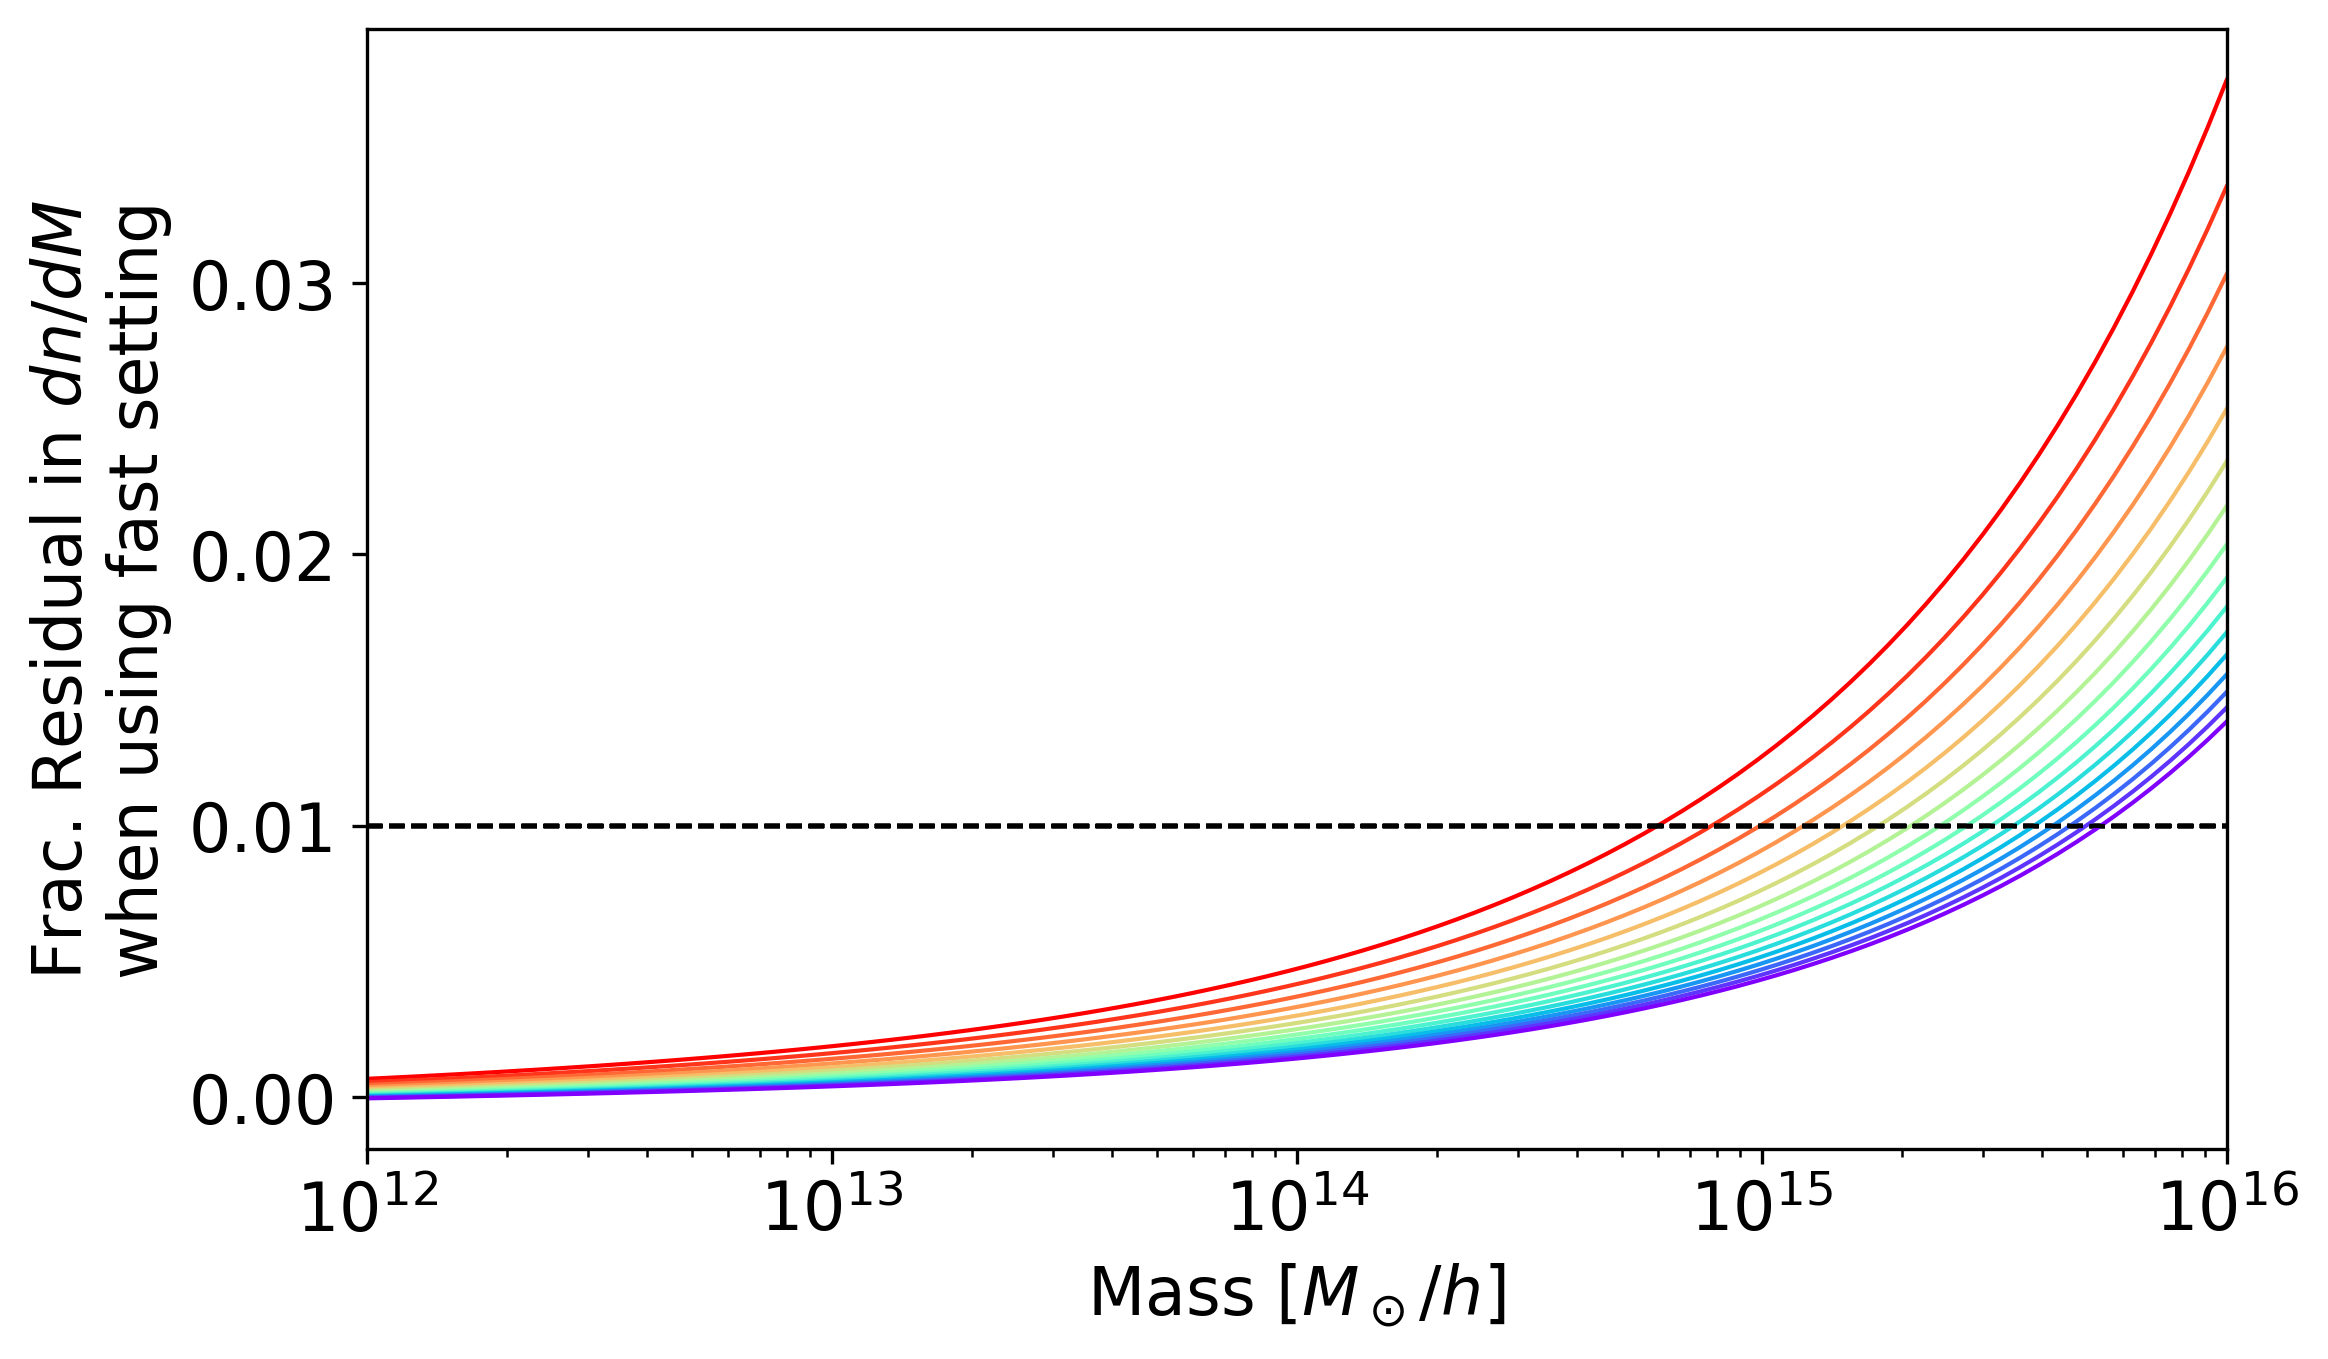

In [20]:
plt.figure(dpi=300, figsize = (8,8/1.618))
for a in a_s:
    
    frac_residual = dn_dM(cosmology, Ms, a) - dn_dM(cosmology, Ms, a, fast = True)
    frac_residual /= dn_dM(cosmology, Ms, a)
    
    plt.plot(Ms, frac_residual,
             lw = 1)
    plt.axhline(0.01, c = 'k', linestyle = '--', lw = 1)
    
plt.xlim(1e12, 1e16)
plt.xlabel(r'Mass [$M_\odot / h$]')
plt.ylabel(r'Frac. Residual in $dn/dM$' + '\n' + 'when using fast setting')

plt.xscale('log')

# Multiplicity Function
We can also look at the multiplicity function or mass function parameters directly 

In [10]:
from aemulusnu_hmf.emulator import multiplicity_function

initializing cosmology. this will only happen once per cosmology


[]

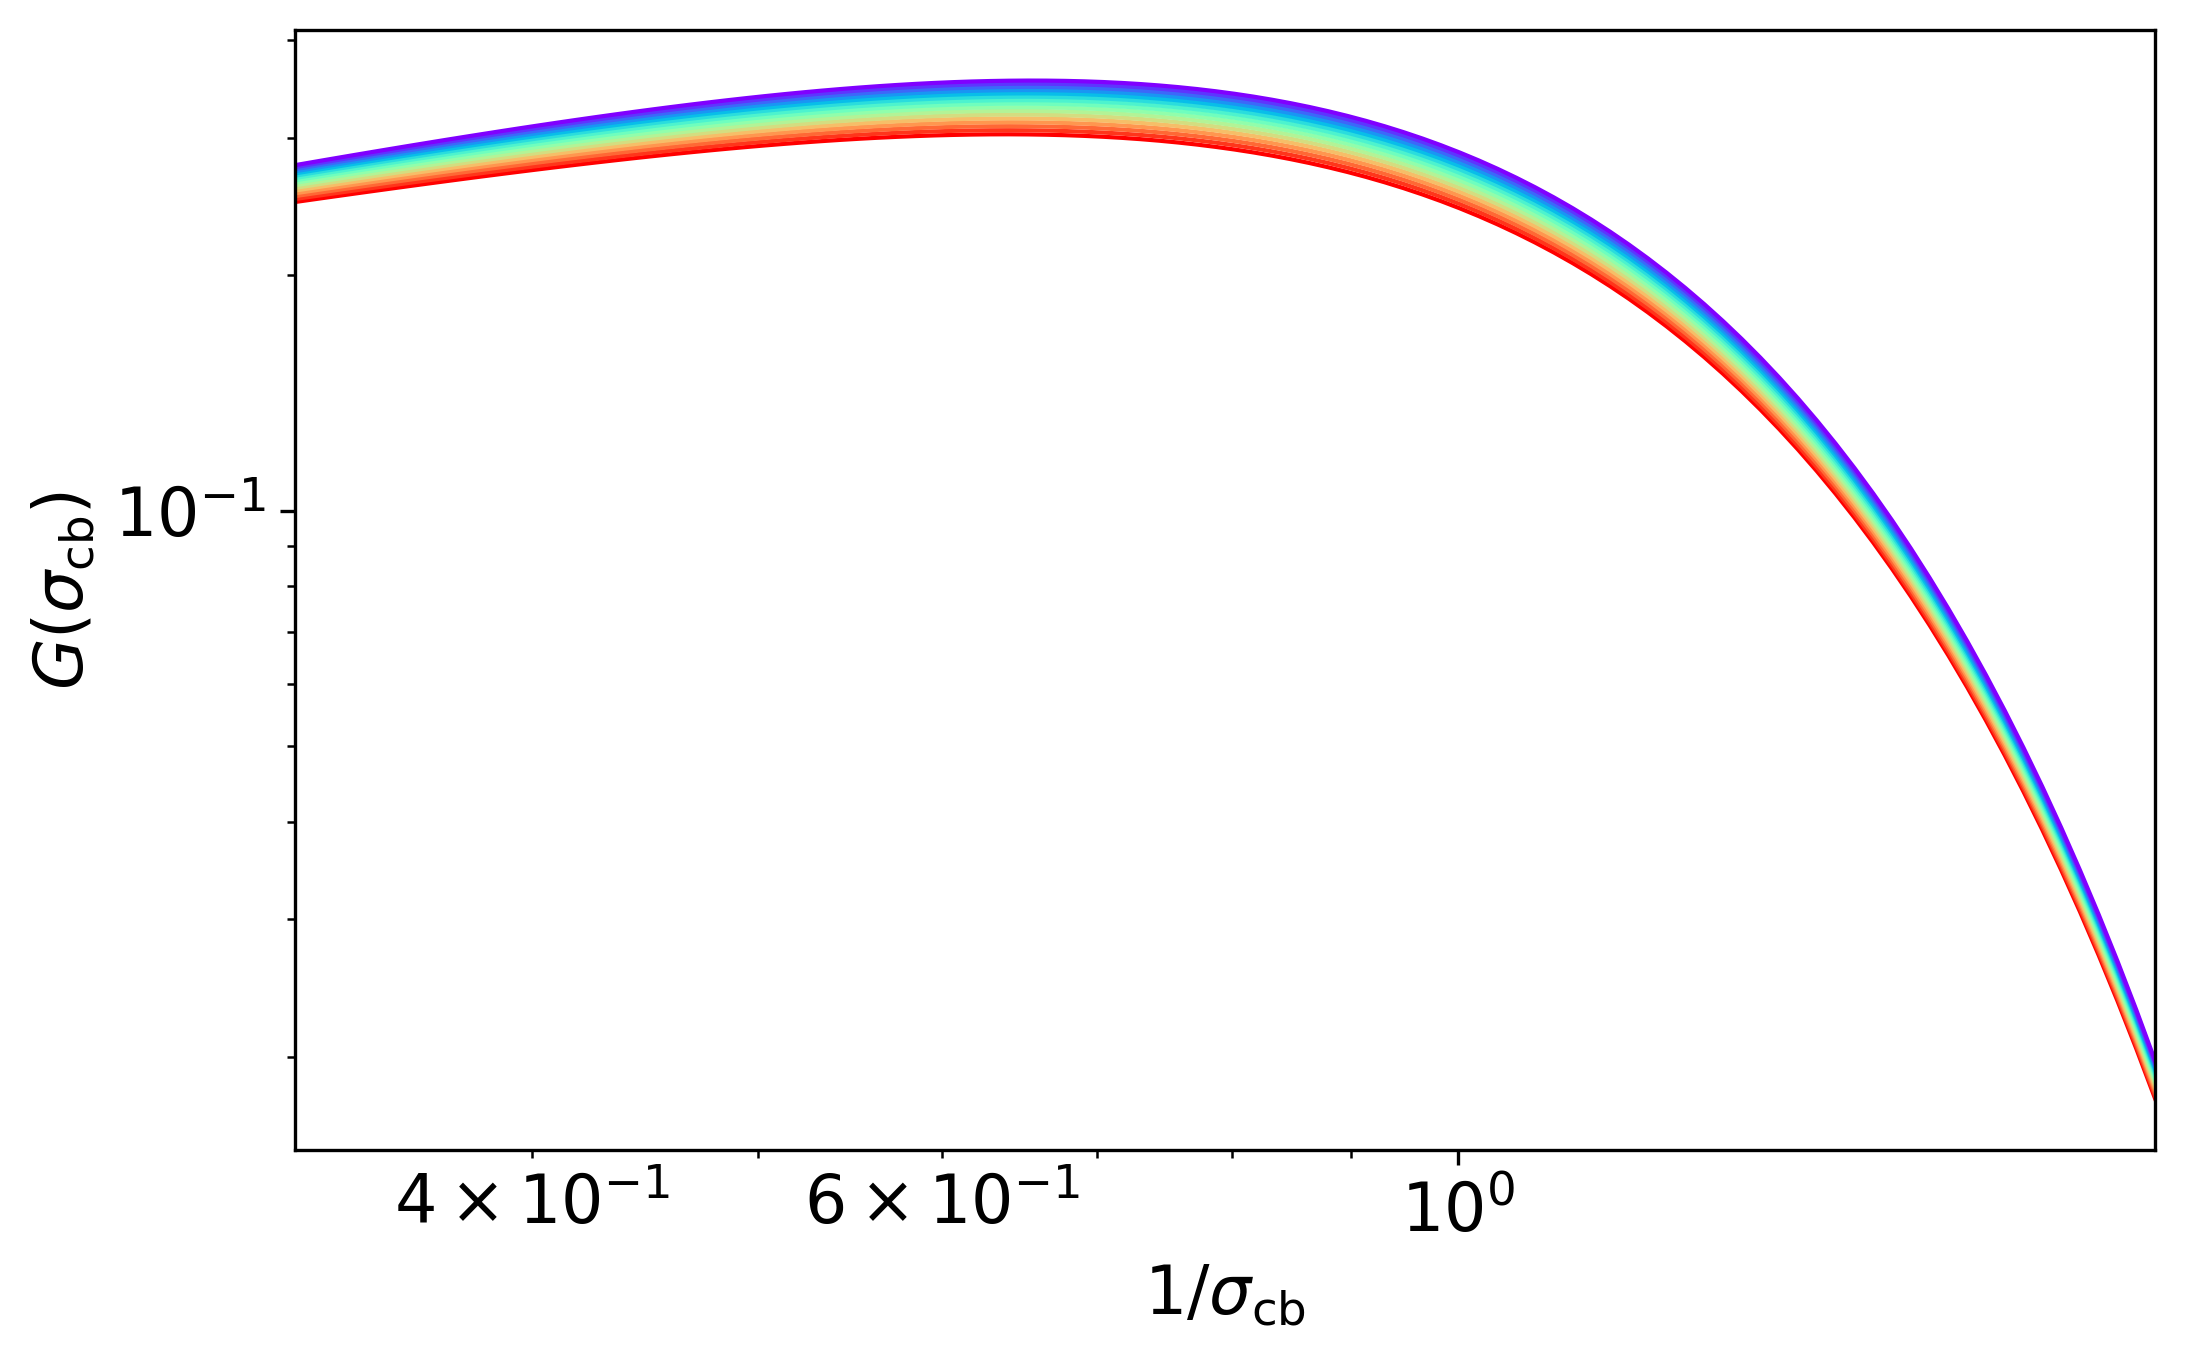

In [11]:
#multiplicity function
plt.figure(dpi=300, figsize = (8,8/1.618))
sigcbs = np.logspace(-0.3, 0.5, 100)

for a in a_s:
    plt.plot(1/sigcbs, multiplicity_function(cosmology, sigcbs, a), 
             lw = 1)
plt.xlabel(r'$1 / \sigma_{\rm cb}$')
plt.ylabel(r'$G(\sigma_{\rm cb})$')
plt.xlim(np.min(1/sigcbs), np.max(1/sigcbs))

plt.loglog()

In [12]:
from aemulusnu_hmf.emulator import predict_params
predict_params(cosmology, 1.0)

{'d': 1.9699358357203927,
 'e': 1.0675332695337614,
 'f': 0.5078125258340683,
 'g': 1.2365210298859044}

# Other cosmology quantities used to compute the Mass Function
Finally you can also take a look at the other cosmology quantities we computed with [`class`](https://lesgourg.github.io/class_public/class.html) that are being used by the mass function. We'll plot $\sigma_{\rm cb}$ here but a list of available quantities:

- `Pcb(k, z)`: linear CDM + baryon power spectrum in units of Mpc^3 / h^3 
- `sigma_cb(M, z)`: $\sigma_{\rm cb}$ as a function of mass and redshift
- `dln_sigma_cb_dM(M, z)`: $d \ln \sigma_{\rm cb} / dM$ as a function of mass and reshift
- `Pm(k, z)`: linear matter power spectrum in units of Mpc^3 / h^3
- `sigma_m(M,z)`: $\sigma_{\rm m}$ as a function of mass and redshift
- `dln_sigma_m_dM(M, z)`: $d \ln \sigma_{\rm m} / dM$ as a function of mass and reshift


In [13]:
from aemulusnu_hmf.emulator import get_cosmology

hmf_cosmology = get_cosmology(cosmology)
print(hmf_cosmology)

[]

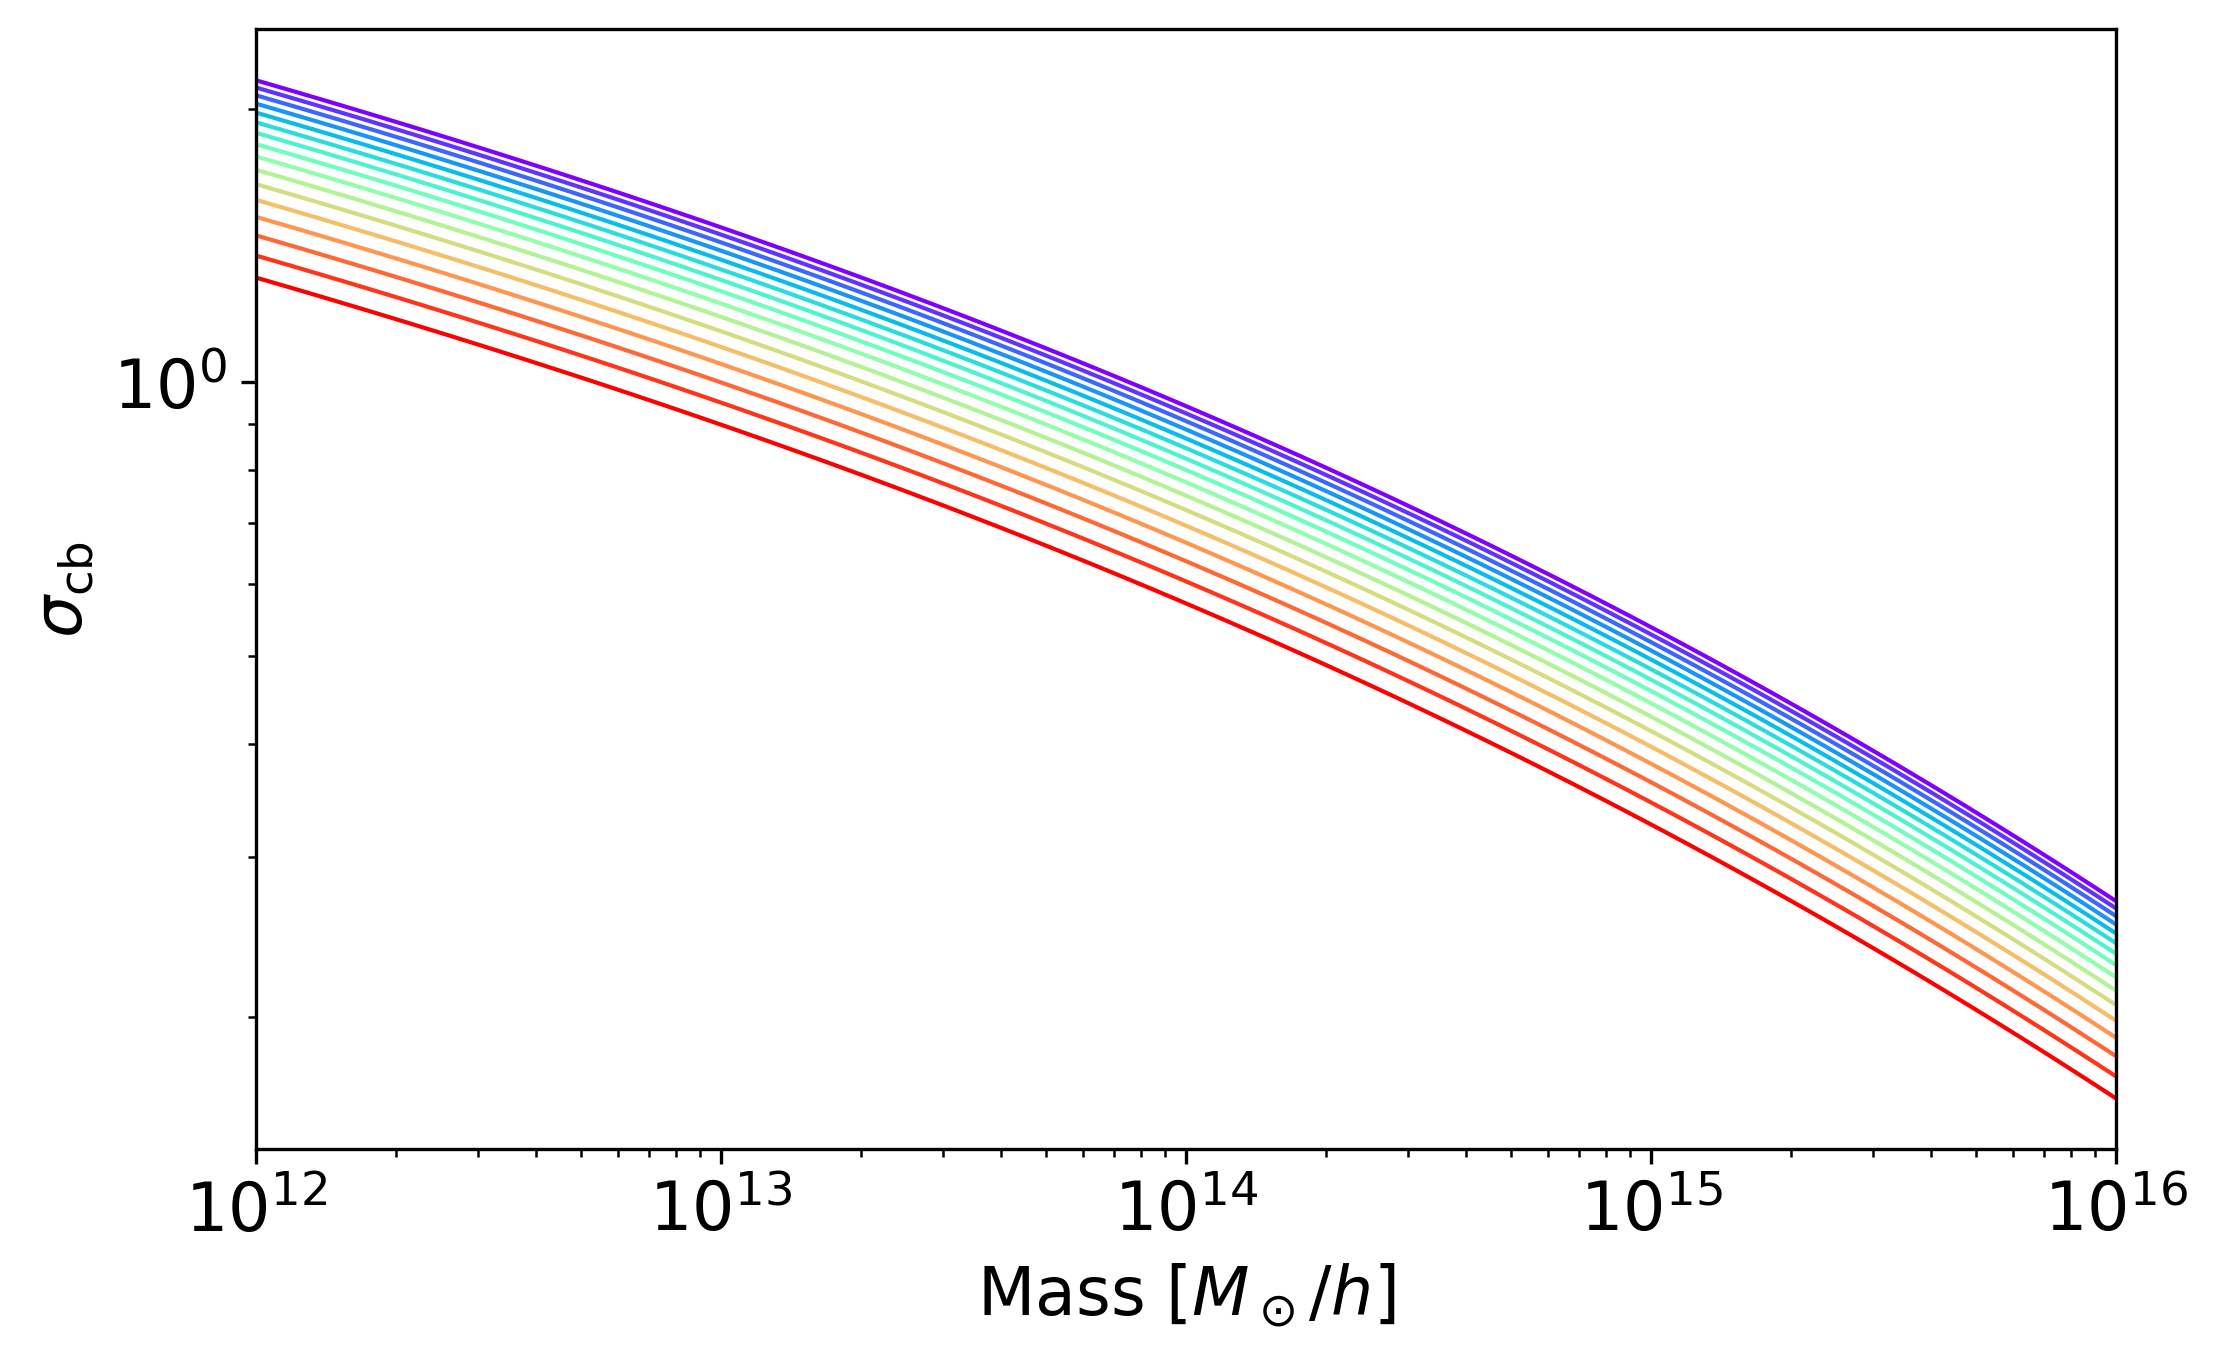

In [14]:
plt.figure(dpi=300, figsize = (8,8/1.618))
for a in a_s:
    plt.plot(Ms, hmf_cosmology.sigma_cb(Ms, z = 1/a - 1),
            lw = 1)

    
plt.xlim(1e12, 1e16)
plt.xlabel(r'Mass [$M_\odot / h$]')
plt.ylabel(r'$\sigma_{\rm cb}$')

plt.loglog()
plt.loglog()